<a href="https://colab.research.google.com/github/ingcoder/NequIP-Tutorial/blob/main/nequip_tutorial_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NequIP Tutorial 
This is an implementation of an NequIP energy and force prediction model in python. 
The trained model is deployed and integrated into LAMMPS MD engine to run an accelerated simulation on a single molecule.
Questions? How does the integration works? How to setup LAMMPS simulation? How to determine performance (accuracy) of the model?

In [1]:
%%capture
# install wandb
!pip install wandb
# install nequip
!git clone --depth 1 "https://github.com/mir-group/nequip.git"
!pip install nequip/
# fix colab imports
import site
site.main()
# set to allow anonymous WandB
import os
os.environ["WANDB_ANONYMOUS"] = "must"
import numpy as np 
import torch 
from ase.io import read, write
np.random.seed(0)
torch.manual_seed(0)

In [2]:
%%capture
# compile lammps
!git clone -b stable_29Sep2021_update2 --depth 1 https://github.com/lammps/lammps.git
!wget "https://github.com/mir-group/pair_nequip/archive/main.zip"
!unzip -q main.zip
!rm main.zip
!mv pair_nequip-main pair_nequip
!cd pair_nequip && ./patch_lammps.sh ../lammps
!pip install mkl mkl-include
!cd lammps && mkdir -p build && cd build && cmake ../cmake -DCMAKE_PREFIX_PATH=`python -c 'import torch;print(torch.utils.cmake_prefix_path)'` && make -j4

In [3]:
# Import modules
import torch
torch.set_default_dtype(torch.float32)
import numpy as np
import logging
import pprint
from nequip.utils.config import Config
from nequip.train.trainer import Trainer
from nequip.data import AtomicDataDict
from nequip.data import AtomicData
from nequip.data import dataset_from_config
from ase.io import read, write

## Download and Visualize Molecule Dataset

In [ ]:
# Remove existing dataset folders and download molecule dataset
!rm -rf ./results/
!rm -rf ./benchmark_data
!rm *.zip
!rm *.npz
!mkdir benchmark_data
!curl http://quantum-machine.org/gdml/data/npz/toluene_ccsd_t.zip -o outfile.zip
!unzip outfile.zip
!y | rm -rf __MACOSX outfile outfile.zip
!mv toluene* ./benchmark_data
!ls benchmark_data


In [ ]:
!pip install nglview
!jupyter-nbextension enable nglview --py --sys-prefix
from google.colab import output
output.enable_custom_widget_manager()

In [30]:
# Visualize
import nglview
from ase.io import read
atoms = read('toluene.xyz', index=0)
nglview.show_ase(atoms)

NGLWidget()

## Set torch geometric training dataset

In [ ]:
# from nequip.data.dataset import NpzDataset
# dataset = NpzDataset('./tutorial_results/')
# logging.info(f"Successfully loaded the data set of type {dataset}...")
npz_files = np.load('benchmark_data/toluene_ccsd_t-train.npz')
npz_files['E'].shape
npz_files['z']
npz_files['name']
print(npz_files.files)
print(npz_files['R'].shape)

In [ ]:
# Load config file
config = Config.from_file('example.yaml')
pprint.pprint(config.as_dict())

In [ ]:
# Instantiate Trainer object trainer with a config file. The trainer handles training as well as call back functions for logging, model saving, and early stopping.
trainer = Trainer(model=None, **dict(config))
trainer.kwargs

In [ ]:
# Load dataset from config file
dataset = dataset_from_config(config, prefix='dataset')
logging.info(f"Successfully loaded the data set of type {dataset}...")
next(iter(dataset))

In [ ]:
trainer.set_dataset(dataset)
trainer.dataset_train.get_data()[0].keys()

In [ ]:
# Normalize training dataset, compute statistics
(
    (forces_std,),
    (energies_mean, energies_std)
) = trainer.dataset_train.statistics(
    fields=[
        AtomicDataDict.FORCE_KEY,
        AtomicDataDict.TOTAL_ENERGY_KEY
    ],
    modes=["rms", "mean_std"],
)
forces_std
energies_std
energies_mean.numpy()

In [ ]:
# 1) Todo: Normalize target (energy and forces)
# result = trainer.dataset_train.get_data()
# energy_minus_mean = result[0]['total_energy'] - energies_mean.numpy()
# energy_normalized = energy_minus_mean * energies_std.numpy()
# trainer.dataset_train.get_data()[0]['total_energy'] = energy_normalized 

## Force and Energy Prediction

In [55]:
# Create model
from nequip.model._grads import ForceOutput
from typing import Optional
import logging
from e3nn import o3
from nequip.data import AtomicDataDict, AtomicDataset
from nequip.nn import (
    SequentialGraphNetwork,
    AtomwiseLinear,
    AtomwiseReduce,
    ConvNetLayer,
)
from nequip.nn.embedding import (
    OneHotAtomEncoding,
    RadialBasisEdgeEncoding,
    SphericalHarmonicEdgeAttrs,
)

from nequip.model import builder_utils

def EnergyModel(
    config, initialize: bool, dataset: Optional[AtomicDataset] = None
) -> SequentialGraphNetwork:
    """Base default energy model archetecture.

    For minimal and full configuration option listings, see ``minimal.yaml`` and ``example.yaml``.
    """
    logging.debug("Start building the network model")

    builder_utils.add_avg_num_neighbors(
        config=config, initialize=initialize, dataset=dataset
    )

    num_layers = config.get("num_layers", 3)

    layers = {
        # -- Encode --
        "one_hot": OneHotAtomEncoding,
        "spharm_edges": SphericalHarmonicEdgeAttrs,
        "radial_basis": RadialBasisEdgeEncoding,
        # -- Embed features --
        "chemical_embedding": AtomwiseLinear,
    }

    # add convnet layers
    # insertion preserves order
    for layer_i in range(num_layers):
        layers[f"layer{layer_i}_convnet"] = ConvNetLayer

    # .update also maintains insertion order
    layers.update(
        {
            # TODO: the next linear throws out all L > 0, don't create them in the last layer of convnet
            # -- output block --
            "conv_to_output_hidden": AtomwiseLinear,
            "output_hidden_to_scalar": (
                AtomwiseLinear,
                dict(irreps_out="1x0e", out_field=AtomicDataDict.PER_ATOM_ENERGY_KEY),
            ),
        }
    )

    layers["total_energy_sum"] = (
        AtomwiseReduce,
        dict(
            reduce="sum",
            field=AtomicDataDict.PER_ATOM_ENERGY_KEY,
            out_field=AtomicDataDict.TOTAL_ENERGY_KEY,
        ),
    )

    return SequentialGraphNetwork.from_parameters(
        shared_params=config,
        layers=layers,
    )

In [ ]:
# Instantiate model
energy_model = EnergyModel(config, initialize=True, dataset=dataset)
force_model = ForceOutput(energy_model)
print(force_model)

In [ ]:
# Training
trainer.model = force_model
trainer.train()

In [ ]:
# 2) Todo: Rescale the output
# Since we normalized the targets, the model will also learn in this normalized space. To go back to our actual space, 
# we have to rescale the output. We do this using the RescaleOutput module which wraps a model -- in our case, our force model -- 
# and rescales its outputs appropriately.
# from nequip.nn import RescaleOutput
# final_model = RescaleOutput(
#     model=force_model, 
#     scale_keys=[AtomicDataDict.TOTAL_ENERGY_KEY, AtomicDataDict.FORCE_KEY],
#     scale_by=forces_std,
#     shift_keys=AtomicDataDict.TOTAL_ENERGY_KEY,
#     shift_by=energies_mean,
# )

In [ ]:
# 3) Todo: Deploy model with python script. !nequip-deploy build --train-dir results/toluene/example-run-toluene toluene-deployed.pth

In [ ]:
# 4) Todo: Validate nequip model on test set

## Inference

In [58]:
# Inference on last frame in dataset
toluene_data = np.load(config.dataset_file_name)
r = toluene_data['R'][-1]
forces = toluene_data['F'][-1]
ATOMIC_NUMBERS_KEY = torch.Tensor(torch.from_numpy(toluene_data['z'].astype(np.float32))).to(torch.int64)

data = AtomicData.from_points(
    pos=r,
    r_max=config['r_max'], 
    **{AtomicDataDict.ATOMIC_NUMBERS_KEY: ATOMIC_NUMBERS_KEY,
    AtomicDataDict.ATOM_TYPE_KEY: torch.zeros_like(ATOMIC_NUMBERS_KEY)
    }
)

In [ ]:
# 5) Todo: Fix RuntimeError: RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!
force_model.eval(); 
pred = force_model(AtomicData.to_AtomicDataDict(data))['forces']

NameError: ignored

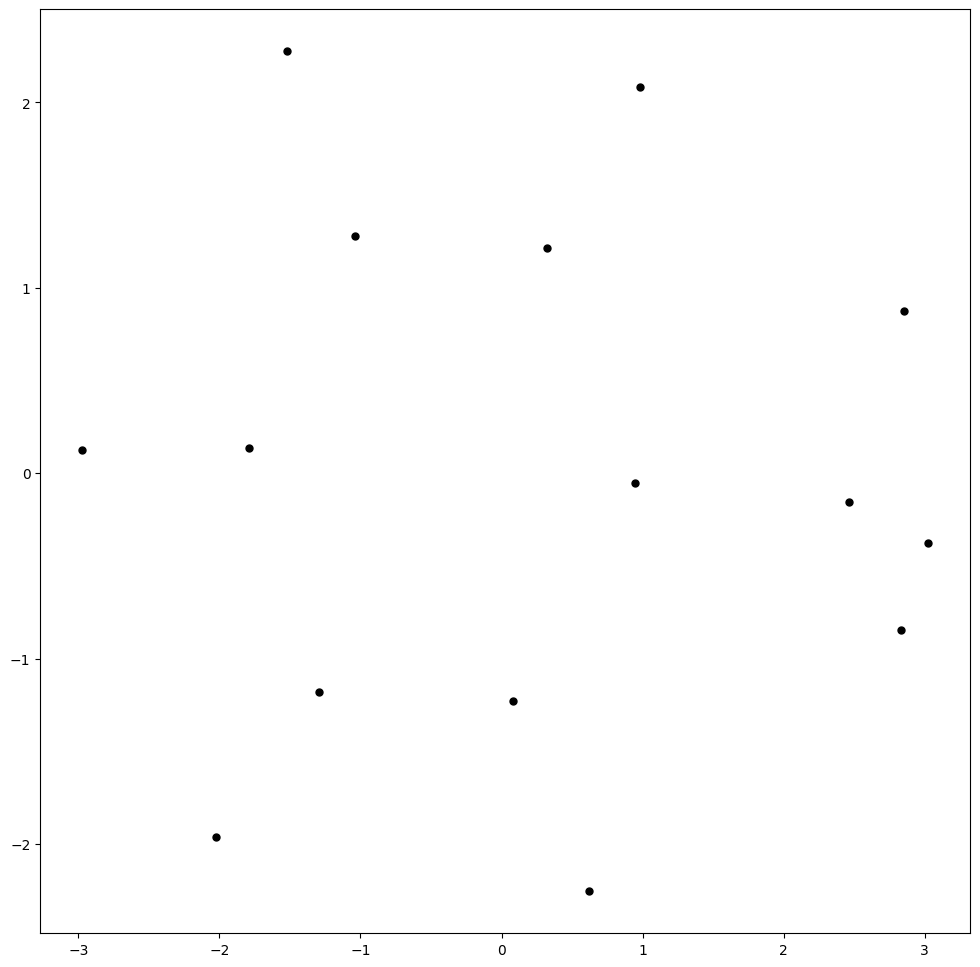

In [60]:
# Plot original and predicted force vectors
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 12))

plt.plot(
    r[:, 0],
    r[:, 1],
    '.k',
    markersize=10,
)

plt.quiver(
    r[:, 0],
    r[:, 1],
    pred[:, 0].detach().numpy(),
    pred[:, 1].detach().numpy(),
    norm=None
)

plt.quiver(
    r[:, 0], 
    r[:, 1], 
    forces[:, 0],
    forces[:, 1],
    color='red', 
    norm=None
)

plt.legend(['Positions', 'Predicted', 'True'], prop={'size': 20})
plt.show()

## MD Simulation with LAMMPS

In [64]:
# How to setup lammps config file?
lammps_input_minimize = """
units	real
atom_style atomic
newton off
thermo 1
read_data structure.data

pair_style	nequip
pair_coeff	* * ../toluene-deployed.pth C H 
mass            1 15.9994
mass            2 1.00794

neighbor 1.0 bin
neigh_modify delay 5 every 1

minimize 0.0 1.0e-8 10000 1000000
write_dump all custom output.dump id type x y z fx fy fz
"""
!mkdir lammps_run
with open("lammps_run/toluene_minimize.in", "w") as f:
    f.write(lammps_input_minimize)

mkdir: cannot create directory ‘lammps_run’: File exists


In [65]:
toluene_example = """15
 Lattice="100.0 0.0 0.0 0.0 100.0 0.0 0.0 0.0 100.0" Properties=species:S:1:pos:R:3 -169777.5840406276=T pbc="F F F"
 C       52.48936904      49.86911725      50.09520748
 C       51.01088202      49.89609925      50.17978049
 C       50.36647401      50.04650925      48.96054247
 C       48.95673398      50.29576626      48.71580846
 C       48.04533296      50.26023426      49.82589448
 C       48.70932398      49.85770925      51.01923950
 C       50.06326400      49.77782925      51.25691751
 H       52.94467905      50.48672926      50.86545150
 H       52.89060405      48.87175023      50.14480949
 H       53.02173405      50.05890725      49.03968247
 H       51.01439802      50.38234726      48.05314045
 H       48.80598498      50.64314926      47.68195744
 H       46.96754695      50.20586626      49.53998848
 H       48.16716997      49.75850325      51.88622952
 H       50.45791001      49.55387424      52.15303052
 """

with open('toluene.xyz', 'w') as f: 
    f.write(toluene_example)

In [66]:
# Convert molecule xyz file to ASE object
atoms = read('toluene.xyz', format='extxyz')

# Perturb positions
p = atoms.get_positions()
p += np.random.rand(15, 3) * 0.5
atoms.set_positions(p)
atoms.set_pbc(False)

# Write to a LAMMPS file
write("lammps_run/structure.data", atoms, format="lammps-data")

In [68]:
# This isn't working because model hasn't been deployed yet
!cd lammps_run/ && ../lammps/build/lmp -in toluene_minimize.in

LAMMPS (29 Sep 2021 - Update 2)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Reading data file ...
  orthogonal box = (0.0000000 0.0000000 0.0000000) to (100.00000 100.00000 100.00000)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  15 atoms
  read_data CPU = 0.003 seconds
NEQUIP is using device cuda
NequIP Coeff: type 1 is element C
NequIP Coeff: type 2 is element H
Loading model from ../toluene-deployed.pth
terminate called after throwing an instance of 'c10::Error'
  what():  Unrecognized data format
Exception raised from load at ../torch/csrc/jit/serialization/import.cpp:449 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x42 (0x7ffb6387f612 in /usr/local/lib/python3.9/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, char const*) + 0x5f (0x7ffb6387bd7f in /usr/local/lib/python3.9/dist-packages/

In [ ]:
# read the final structure back in 
minimized = read('./lammps_run/output.dump', format='lammps-dump-text')

In [ ]:
# get distances of optimized geometry (reference data: CCSD(T) [Psi4, cc-pVDZ])
d_12 = minimized.get_distances(1, 2)

# reference: https://cccbdb.nist.gov/geom3x.asp?method=6&basis=2, coupled cluster
d_12_ccd = 1.4086

print('Relative Error in bond length w.r.t. Coupled Cluster from CCCBDB: {:.3f}%'.format((100 * np.abs(d_12 - d_12_ccd) / d_12_ccd)[0]))